# Майнор по Анализу Данных, Группа ИАД-4
## 12/10/2017 Обратное распространение ошибок

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

## Почему *обратное* распространение?

### Обозначения и затравочка

Рассмотрим такой пример нейронной сети.

<center><img src='images/nn.png'></center>

* $x_i$ - входной слой. Сюда подаются признаки объектов. $i$ - это индексы признаков объекта
* $z_j$, $z_k$ - скрытые слои.
* $z_m$ - выходной слой. Тут выводятся результаты вычислений сети. $j$, $k$, $m$ - индексы нейронов в этих слоях
* $w_{\cdot,\cdot}$ - веса, связывающие нейроны соседних слоев

Дополнительно введем следующие обозначения:
* $net^{(1)}_j = net_j = \sum_iw_{ij}x_i$ 
* $net^{(2)}_k = net_k =  \sum_jw_{jk}z_j$ 
* $net^{(3)}_m = net_m \sum_kw_{km}z_k$

*Верхние индексы мы пока опустим, но в части про векторизацию к ним вернемся*


Так же:
* $z_j = f^{(h)}(net_j)$ 
* $z_k = f^{(k)}(net_k)$
* $z_m = f^{(r)}(net_m)$

где $f(\cdot)$ - некоторая функция активации.

Нам так же понадобится функция потерь $L(W)$, которая зависит от весов $w_{\cdot, \cdot}$.

Если бы мы хотели обучаться с помощью простого градиентного спуска, то нам нужно было на каждом шаге расчитывать
частные производные по всем весам: 

$\frac{\partial L}{\partial w_{ij}}$, $\frac{\partial L}{\partial w_{jk}}$, $\frac{\partial L}{\partial w_{km}}$

Достаточно выписать вычисления нейронной сети в виде формулы, чтобы понять, что "такой футбол нам не нужен" и хоть и вычислять эти производные можно, это займет много времени. Есть ли способ как-то ускорить расчет производных?

### Идея метода

Поступим следующим образом - случайно инициализируем начальные веса и пропустим один объект $(x(t), y(t))$ по нейронной сети с прямом направлении (forward pass). Получим ответ нейронной сети на одном из выходов $z_m = \hat{y}(t)$.

Посчитаем $\frac{\partial L}{\partial w_{km}}$, воспользовавшись правилами дифференцирования сложных функций:

$$
\begin{align*} 
\frac{\partial L}{\partial w_{km}} &=  \underline{\frac{\partial L}{\partial z_m} \cdot \frac{\partial z_m}{\partial net_m}} \cdot \frac{\partial net_m}{\partial w_{km}} \\ 
 &= \underline{\frac{\partial L}{\partial z_m} \cdot f^{(3)`}(net_m)} \cdot z_k
\end{align*}
$$
*Первые два члена выделены неслучайно!*

Okey, пока ничего особенного. Переходим на слой назад:
$$
\begin{align} 
\frac{\partial L}{\partial w_{jk}} &=  (\frac{\partial L}{\partial z_k}) & \cdot & \frac{\partial z_k}{\partial net_k} & \cdot & \frac{\partial net_k}{\partial w_{jk}} \\ 
 &= \left(\sum_m\underline{\frac{\partial L}{\partial z_m} \cdot \frac{\partial z_m}{\partial net_m}} \cdot \frac{\partial net_m}{\partial z_k}\right) & \cdot & f^{(2)`}(net_k) & \cdot & z_j \\
 &= \left(\sum_m\underline{\frac{\partial L}{\partial z_m} \cdot f^{(3)`}(net_m)} \cdot w_{km}\right) & \cdot & f^{(2)`}(net_k) & \cdot & z_j \\
\end{align}
$$
*Надеюсь форматирование вас не запутало*

Что же мы видим? Некоторую часть выражения для $\frac{\partial L}{\partial w_{jk}}$ мы уже считали на слое выше! Причем эта часть отвечает именно за производную ошибки по выходу сети! Более того, эта часть входит с весом $ w_{km}$, который как раз связывает эти слои. Таким образом, можно сказать, что ошибка начинает *распростроняться в обратном направлении* по слоям, пропоционально весам между слоями. 

Отсюда и название метода.

Eсли мы продолжим вывод для весов $w_{ij}$, то так же заметим там часть, ранее посчитанную на этапе с весами $w_{jk}$



### Обобщение

Становится ясно, что можно как-то записать вычисление в "рекурсивном" виде между слоями.

Пусть один объект прошел по сети с результатом $\hat{y}(t)$.

Рассмотрим выражение для нейрона $l$
$$ \delta_l = \frac{\partial L}{\partial net_l} = \frac{\partial L}{\partial \hat{y}(t)} \cdot \frac{\partial \hat{y}(t)}{\partial net_l}$$
и назовем это **сигнал об ошибке**, проходящий через нейрон $l$.

Если нейрон $l$ находится на выходном слое, то просто считаем $\frac{\partial L}{\partial \hat{y}(t)}$, а $\frac{\partial \hat{y}(t)}{\partial net_l} = \frac{\partial z_l}{\partial net_l} = f^{`}(net_l)$

Eсли нейрон $l$ находится в промежуточном слое, то $\frac{\partial \hat{y}(t)}{\partial net_l}$ надо расписать через нейроны следующего (в направлении выхода сети) слоя:

$$
\begin{align} 
\frac{\partial \hat{y}(t)}{\partial net_l} &= \frac{\partial \hat{y}(t)}{\partial z_l} & \cdot \frac{\partial z_l}{\partial net_l} \\ 
&= \sum_{o \in out(l)} \left(\frac{\partial \hat{y}(t)}{\partial net_o} \cdot \frac{\partial net_o}{\partial z_l} \right) & \cdot f^{`}(net_l) \\
&= \sum_{o \in out(l)} \left(\frac{\partial \hat{y}(t)}{\partial net_o} \cdot w_{lo} \right) & \cdot f^{`}(net_l) 
\end{align}
$$ 

Теперь доставим это выражение в "определение" $\delta_l$:
$$
\begin{align} 
\delta_l &=  \frac{\partial L}{\partial \hat{y}(t)} \cdot \frac{\partial \hat{y}(t)}{\partial net_l} \\ 
&= \frac{\partial L}{\partial \hat{y}(t)} \cdot \sum_{o \in out(l)} \left(\frac{\partial \hat{y}(t)}{\partial net_o} \cdot w_{lo} \right) \cdot f^{`}(net_l) \\
&=  \sum_{o \in out(l)} \left(\frac{\partial L}{\partial \hat{y}(t)} \cdot \frac{\partial \hat{y}(t)}{\partial net_o} \cdot w_{lo} \right) \cdot f^{`}(net_l) \\
&=  \sum_{o \in out(l)} \left(\delta_o \cdot w_{lo} \right) \cdot f^{`}(net_l) \\
\end{align}
$$ 

Красота!



### В итоге - шаги алгоритма backpropagation

Ниже преставленны шаги алгоритма обратного распространения ошибки с проходом одним случайным объектом. Проход всеми объектами выборки или батчем получается из данной записи очевидным образом.

1. Некоторым образом инициализируем все веса сети
2. Прогоняем случайный объект $x(t)$ по сети, попутно запоминая все $net_l$ и $z_l$ для всех слоев
3. Считаем $\delta_l$: если слой  $l$ выходной, то 
$$ \delta_l = f^{(l)`}(net_l) \frac{\partial L}{\partial \hat{y}(t)} $$
иначе 
$$ \delta_l = f^{(l)`}(net_l) \sum_{o \in out(l)} \delta_o w_{lo}$$
4. Обновляем веса по следующему правилу
$$ w_{jk} = w_{jk} - \alpha \cdot \delta_k \cdot z_j $$
5. Если правило останова не выполнено, перейти к шагу 2

## Векторизация

### Прямой проход

Понятно, что операции, которые проходят в нейронной сети можно векторизовать.

Например, умножение на веса и переход к следующему слою можно просто расписать в виде умножения на матрицу:

$$\left\{net^{(1)}_j\right\}^{J}_{j=1} = \left\{ \sum_iw_{ij}x_i \right\}^{J}_{j=1} = W^{i \rightarrow j}x = net^{(1)} $$

Eсли же мы хотим применить какую-то функцию активации $f(\cdot)$, то смело поэлементно применяем ее к $net^{(1)}$

$$ Z^{(1)} = f(net^{(1)}) $$

<center><img src='images/vect.png'></center>

Таким образом, все что происходит в полносвязной сети можно реализовать с помощью матричных операций.
Например, сеть с двумя слоями с сигмойдными функциями активации записывается как

$$y = \sigma(W_2\sigma(W_1x)) $$

### Обратный проход

Запишем сигнал об ошибке
$$ \left\{\delta_l\right\}^{L}_{l=1} = \left\{ f^{(l)`}(net_l) \sum_{o \in out(l)} \delta_o w_{lo} \right\}^{L}_{l=1}$$
в векторизованном виде:

$$
\Delta^{(1)} = f^{`}(net^{(1)}) \odot \Delta^{(2)} W^{(1 \rightarrow 2)}
$$
а для выходново слоя
$$
\Delta^{(out)} = f^{`}(net^{(out)}) \odot \frac{\partial L}{\partial \hat{y}}
$$


Тогда веса следует обновлять так:

$$ W^{(1 \rightarrow 2)} = W^{(1 \rightarrow 2)} - \alpha Z^{{(1)}^\top} \Delta^{(2)} $$

И так для всех слоев

<center><img src='images/back.png'></center>

## Практика

Основано на материале из [cs231n](http://cs231n.github.io/neural-networks-case-study/).

Возьмем какой-нибудь простой датасет для классификации и обучим на нем нейронную сеть с одним скрытым слоем с функцией активации ReLU. <br\>
На выходе, расчеты должны пройти через SoftMax.
$$z_l = \frac{\exp(net_l)}{\sum_l \exp(net_l)} \text{ - это softmax}$$
Таким образом, нейронная сеть должна для каждого класса возвращать вероятность принадлежности ему объекта, который через нее прошел.

Ошибка в нашем случае будет выражаться как кросс-энтропия. Величину ошибки на одном объекте вычиляем так
$$L(\hat{y}(t)) = - \sum\limits_{c \in classes} y_c\log(\hat{y}_c)$$
Общая ошибка с регуляризацией:
$$L = \frac{1}{N}\sum\limits_{t=1}^N L(\hat{y}(t)) + \lambda\frac{1}{2}\|\mathbf{W}\|^2$$

In [36]:
from sklearn.datasets import make_moons

In [37]:
N = 100 # кол-во объектов
D = 2 # кол-во признаков
K = 2 # кол-во классов
X, y = make_moons(n_samples=N, noise=0.1, random_state=123)
C = 0.01 # гиперпараметр регуляризации

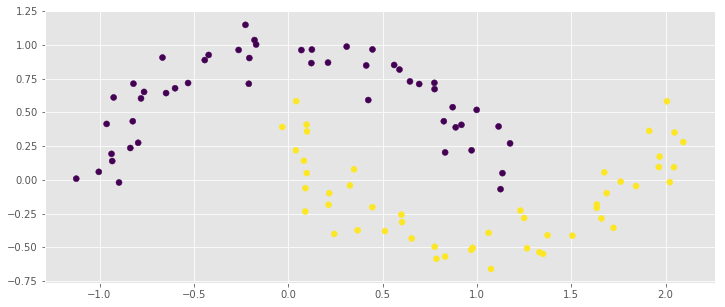

In [38]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Удобно сделать one-hot encoding для кодирования истинной метки классов объектов

In [39]:
y_bool = np.zeros((N, K))
y_bool[range(N), y] += 1

Задаем колиество нейронов в первом слое и веса

In [40]:
h = 50 
# Матрица весов между 
# входным слоем и промежуточным скрытым
W = 0.01 * np.random.randn(D,h) 
b = np.zeros((1,h)) # св член

# Матрица между промежуточным
# скрытым слоем и выходным слоем
W2 = 0.01 * np.random.randn(h,K) 
b2 = np.zeros((1,K)) # св член

In [41]:
W2.shape

(50, 2)

### Прямой проход

In [42]:
# Прогоняем всю выборку через сеть
hidden_layer = np.maximum(0, np.dot(X, W) + b) 
scores = np.dot(hidden_layer, W2) + b2 # "Сырой" выход сети
probs = np.exp(scores)/np.exp(scores).sum(axis=1, keepdims=True)

In [43]:
errors = -(y_bool * np.log(probs))

In [44]:
total_error = errors.sum()
print(total_error)

69.3193627525


Обратите внимание, что на каждом сле у нас есть свободный член b и b2. У них тоже есть веса и их надо учитывать

## Обратный проход

Начинаем с того, что с считаем $\Delta^{(out)}$ на выходном слое.

Оказывется, что в случае с softmax и кросс-энтропией $\Delta^{(out)}$ будет выражаться очень просто!

$$ \Delta^{(out)} = \hat{y} - y $$

In [45]:
dscores = probs - y_bool

In [46]:
dscores.shape

(100, 2)

Таким образом градиент на веса между выходным и скрытым слоем выражается как 

$$\Delta W_2 = Z^{{(1)}^\top}\Delta^{(out)}$$

In [47]:
# производные по весам
# между выходным и конечным слоем
dW2 = np.dot(hidden_layer.T, dscores) + C*W2 # Не забываем регуляризацию

# производная по весам для свободного члена
db2 = np.sum(dscores, axis=0, keepdims=True)


Идем дальше

$$\Delta^{(1)} = f^{`}(net^{(1)}) \odot D^{(2)} W^{(1 \rightarrow 2)}$$

In [48]:
## Это просто пошагово
# dhidden_rpart = np.dot(dscores, W2.T) # Правая часть выражения
# dhidden_lpart = (hidden_layer <= 0).astype(int) # Производная ReLU
# dhidden = dhidden_lpart * dhidden_rpart # Результат

dhidden = np.dot(dscores, W2.T)
dhidden[hidden_layer <= 0] = 0

Таким образом градитент по весам

In [49]:
dW = np.dot(X.T, dhidden) + C*W
db = np.sum(dhidden, axis=0, keepdims=True)

Вот и все, дальше нужно итеративно обновлять веса